In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
def create_model(num_classes):
    # Load a pre-trained EfficientNet-B0 model
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)   
    
    return model


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
model = create_model(1).to(device)

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
transform = transforms.Compose([
   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for EfficientNet
])

In [7]:
dataset = datasets.ImageFolder("./Dataset_Randstain", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [10]:
num_epochs = 50

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        # Calculate training accuracy
        predicted_train = torch.sigmoid(outputs).squeeze() > 0.5
        correct_train += (predicted_train == labels).sum().item()
        total_train += labels.size(0)
    
    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            
            predicted_val = torch.sigmoid(outputs).squeeze() > 0.5
            correct_val += (predicted_val == labels).sum().item()
            total_val += labels.size(0)
        
    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    


In [23]:
# Save training and validation metrics
np.save('./models/EfficientNetB0_randstain_no_early_stop_no_aug/train_losses.npy', np.array(train_losses))
np.save('./models/EfficientNetB0_randstain_no_early_stop_no_aug/val_losses.npy', np.array(val_losses))
np.save('./models/EfficientNetB0_randstain_no_early_stop_no_aug/train_accuracies.npy', np.array(train_accuracies))
np.save('./models/EfficientNetB0_randstain_no_early_stop_no_aug/val_accuracies.npy', np.array(val_accuracies))

# Save the model
torch.save(model, './models/EfficientNetB0_randstain_no_early_stop_no_aug/efficientNetB0.pth')

In [24]:
loaded_model = torch.load('./models/EfficientNetB0_randstain_no_early_stop_no_aug/efficientNetB0.pth')

In [25]:
all_preds, all_targets = [], []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = loaded_model(inputs)
        probs = torch.sigmoid(outputs).squeeze()
        preds = probs > 0.5
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.87      0.89      0.88        44
   Cancerous       0.76      0.73      0.74        22

    accuracy                           0.83        66
   macro avg       0.81      0.81      0.81        66
weighted avg       0.83      0.83      0.83        66



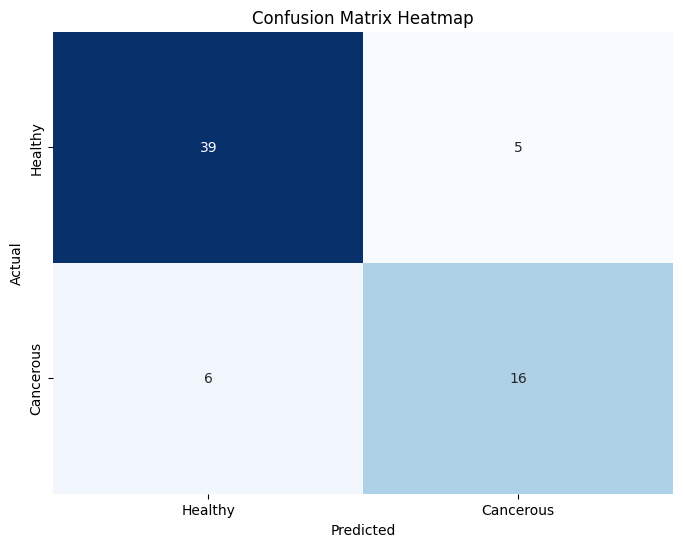

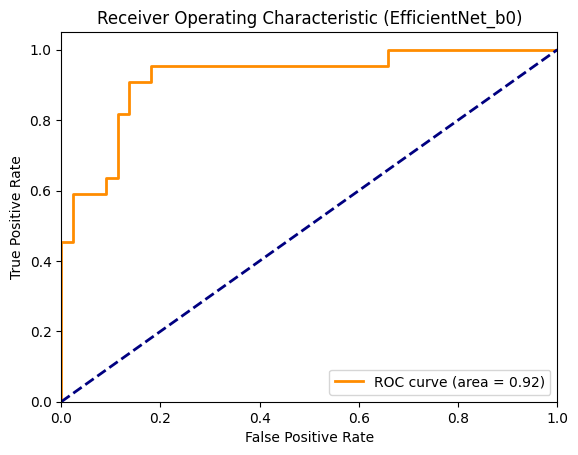

In [26]:
# Print classification report
print("\nClassification Report:")
print(classification_report(all_targets, np.array(all_preds).flatten(), target_names=['Healthy', 'Cancerous']))

# Plot confusion matrix heatmap
conf_matrix = confusion_matrix(all_targets, np.array(all_preds).flatten())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Healthy', 'Cancerous'], yticklabels=['Healthy', 'Cancerous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (EfficientNet_b0)')
plt.legend(loc="lower right")
plt.show()

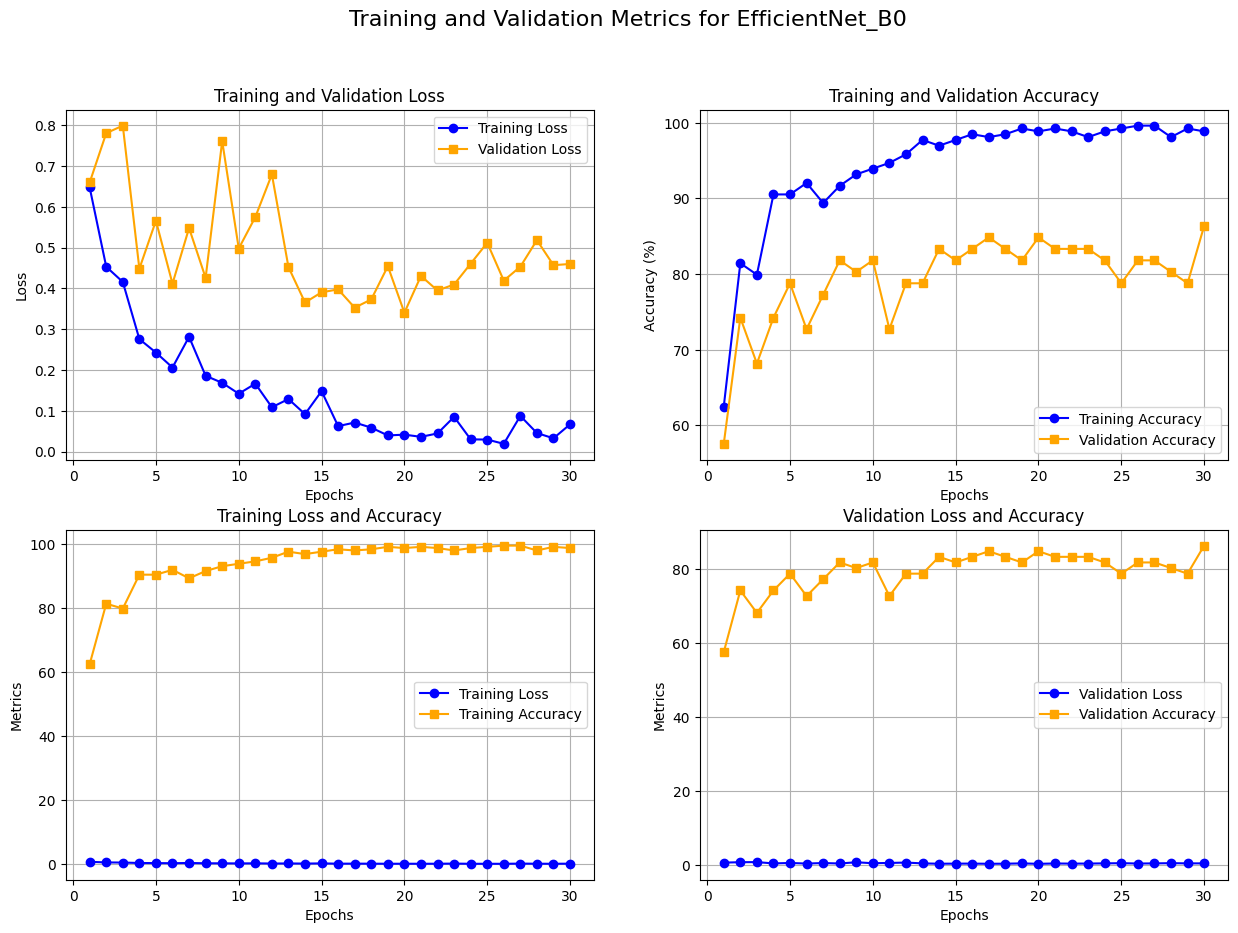

In [28]:

train_losses = np.load('./models/EfficientNetB0_randstain_no_early_stop_no_aug/train_losses.npy')
val_losses = np.load('./models/EfficientNetB0_randstain_no_early_stop_no_aug/val_losses.npy')
train_accuracies = np.load('./models/EfficientNetB0_randstain_no_early_stop_no_aug/train_accuracies.npy')
val_accuracies = np.load('./models/EfficientNetB0_randstain_no_early_stop_no_aug/val_accuracies.npy')


num_epochs = len(train_losses)


fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting Training and Validation Loss
axs[0, 0].plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')
axs[0, 0].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s', color='orange')
axs[0, 0].set_title('Training and Validation Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plotting Training and Validation Accuracy
axs[0, 1].plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
axs[0, 1].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='s', color='orange')
axs[0, 1].set_title('Training and Validation Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy (%)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plotting Training Loss and Accuracy together
axs[1, 0].plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')
axs[1, 0].plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='s', color='orange')
axs[1, 0].set_title('Training Loss and Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Metrics')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plotting Validation Loss and Accuracy together
axs[1, 1].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o', color='blue')
axs[1, 1].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='s', color='orange')
axs[1, 1].set_title('Validation Loss and Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Metrics')
axs[1, 1].legend()
axs[1, 1].grid(True)


fig.suptitle('Training and Validation Metrics for EfficientNet_B0', fontsize=16)



plt.show()

In [17]:
from PIL import Image

Image tensor shape: torch.Size([1, 3, 128, 128]), Image tensor dtype: torch.float32
Model output: tensor([[8.7825]])
Predicted index: True


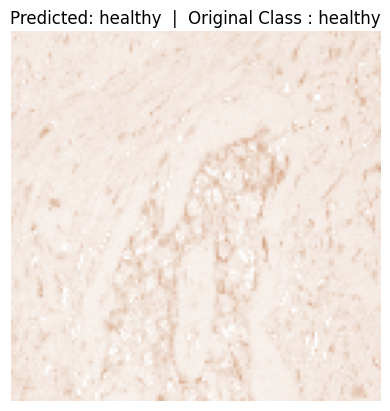

In [18]:
class_labels = ["cancer","healthy"]

def predict_image(image_path,model=loaded_model):
   
    image = Image.open(image_path).convert('RGB')  
    image_tensor = transform(image)  
    image_tensor = image_tensor.unsqueeze(0) 


    print(f"Image tensor shape: {image_tensor.shape}, Image tensor dtype: {image_tensor.dtype}")

  
    with torch.no_grad():
        outputs = model(image_tensor)
     
        print(f"Model output: {outputs}")
       
        probabilities = torch.sigmoid(outputs).squeeze()
        predicted = probabilities > 0.5
        
        
        print(f"Predicted index: {predicted.item()}")

        predicted_class = class_labels[int(predicted.item())]

    return predicted_class, image

def plot_prediction(image_path):
    predicted_class, image = predict_image(image_path)

    if "cancer" in image_path.lower():
        original_class = "cancer"
    else:
        original_class = "healthy"

    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}  |  Original Class : {original_class}')
    plt.axis('off') 
    plt.show()


image_path = './Dataset/HEALTHY/10156 (12).png'
plot_prediction(image_path)